In [1]:
#import matplotlib.pyplot as plt
#import numpy as np
#import seaborn as sns
#import math
#from scipy import stats
#print("imported " + str(len(raw)) + " rows")
#raw.columns.tolist()

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate
import numpy as np
from matplotlib import cm
raw = pd.pandas.read_csv('../setup_data/pred_1x1_20181206.csv',sep=",",low_memory=False)

## Functions

def print_list(list_in):
    display(HTML(tabulate.tabulate(list_in, tablefmt='html')))

# Setup Data Set

In [397]:
data = raw.copy()
data['published_week_dt'] = pd.to_datetime(raw_2['published_week'])


Index(['published', 'sold_date', 'object_type', 'living_area', 'rooms',
       'floor', 'rent', 'list_price', 'sold_price', 'sold_price_source',
       'construction_year', 'apartment_number', 'distance_ocean',
       'source_name', 'source_type', 'source_id', 'plot_area',
       'published_week', 'published_month', 'sold_week', 'sold_month',
       'sqm_list_price', 'sqm_sold_price', 'sqm_rent_price', 'area_from_geo',
       'min_distance_to_metro', 'date_time', 'datetime', 'published_dt',
       'published_week_dt', 'sqm_sold_price_rolling_7d',
       'sqm_sold_price_rolling_14d', 'sqm_sold_price_rolling_21d',
       'sqm_sold_price_rolling_100d'],
      dtype='object')


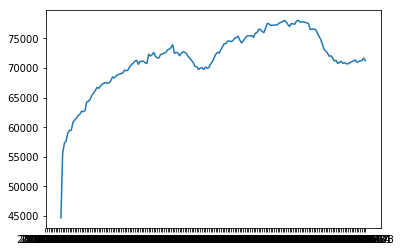

In [419]:
## calculate new variables
def rolling_avg(df,rolling_interval,variable):
    # make copy of df and set new index
    tmp_df = df.copy()
    tmp_df['sold_dt'] = pd.to_datetime(tmp_df['sold_date'])
    tmp_df = tmp_df.set_index('sold_dt')
    
    # create series of the variable we want to do rolling over
    sold_price = tmp_df[[variable]]
    # calculate mean per week and calculate rooling for 'rolling_interval'
    rolling_var = sold_price.resample('W-MON').mean().sort_index().rolling(rolling_interval).mean()
    rolling_var.columns = [variable+'_rolling_'+rolling_interval]
    
    # Merge dataframes
    df = pd.merge(df, rolling_var, left_on = 'published_week_dt', right_index=True, how = 'left')
    return df


#hej = data[data['published'] > '2018-01-01']
##pd.to_datetime(hej['sold_date'])
data_w_feature = rolling_avg(data,'7d','sqm_sold_price')
data_w_feature = rolling_avg(data_w_feature,'14d','sqm_sold_price')
data_w_feature = rolling_avg(data_w_feature,'21d','sqm_sold_price')
data_w_feature = rolling_avg(data_w_feature,'100d','sqm_sold_price')

#print(data_w_feature[['published','sqm_sold_price_rolling_7d','sqm_list_price']].head(10))


print(data_w_feature.columns)
#plt.plot(data_w_feature.groupby(['published_week'])['sqm_sold_price_rolling_7d'].mean())
#plt.plot(data_w_feature.groupby(['published_week'])['sqm_sold_price_rolling_14d'].mean())
#plt.plot(data_w_feature.groupby(['published_week'])['sqm_sold_price_rolling_21d'].mean())
plt.plot(data_w_feature.groupby(['published_week'])['sqm_sold_price_rolling_100d'].mean())

plt.show()

In [379]:
#print(hej1)
#new_df = pd.merge(data, num_sold_14d, left_on = 'published_week_dt', right_index=True, how = 'left')
#print(new_df[['published','num_sold_14d']].head())
print(data[['published','num_sold_14d']].head())

KeyError: "['num_sold_14d'] not in index"

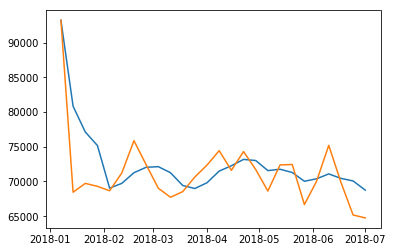

In [271]:
#[str(x) for x in raw["published"]]
#data['2018-01-01':'2018-12-30'].resample('W').count().sort_index()
plt.plot(data['2018-01-01':'2018-06-30'].resample('W').mean().sort_index().rolling('28d').mean())
plt.plot(data['2018-01-01':'2018-06-30'].resample('W').mean())
plt.show()

In [215]:
print(data['2018-01-01':'2018-06-30'].resample('W').count().sort_index().head(10))
print(data['2018-01-01':'2018-06-30'].resample('W').count().sort_index().rolling('14d').sum().head(10))

            sqm_sold_price
datetime                  
2018-01-07               3
2018-01-14              48
2018-01-21              75
2018-01-28              71
2018-02-04              72
2018-02-11              85
2018-02-18              64
2018-02-25             103
2018-03-04              83
2018-03-11              43
            sqm_sold_price
datetime                  
2018-01-07             3.0
2018-01-14            51.0
2018-01-21           123.0
2018-01-28           146.0
2018-02-04           143.0
2018-02-11           157.0
2018-02-18           149.0
2018-02-25           167.0
2018-03-04           186.0
2018-03-11           126.0


In [343]:
a = raw_2[raw_2['published'] > '2018-04-01'][['sold_date','published','published_dt','published_week']]
b = data['2018-04-01':'2018-06-01'].resample('W-MON').count().sort_index().rolling('14d').sum()
b.columns = ['sum_sold_2w']
print(a.head())
print(b)
print(len(a))
print(len(b))
#left_index=True, right_on='Project'
#new_df = pd.merge(a,b,  how='left', left_index=True ,right_on='sum_sold_2w')
new_df = pd.merge(a, b, left_on = 'published_dt', right_index=True, how = 'left')
print(len(new_df))
print(new_df)

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [2018-04-01] of <class 'str'>

In [3]:
### CLEAN DATA FUNC

def clean_func(data,predictors):
    
    ## DO IMPUTATION 
    # living_area
    floor = Imputer(missing_values="NaN", strategy="mean")
    floor.fit(data[["floor"]])
    data['floor'] = floor.transform(data[["floor"]]).ravel()
    
    ## REMOVE ROWS w. NULL
    data = data[pd.notnull(data[predictors]).all(axis=1)]
    return data


In [4]:
## set predictors
predictors = ['min_distance_to_metro','living_area'
              ,'floor','sqm_list_price','sqm_rent_price'
              ,'area_from_geo']

## set numeric predictors
num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','uint8']
train_data_numerics = raw[predictors].select_dtypes(include=num_types).columns

In [5]:
## Set target and clean data (se function above)
target = 'sqm_sold_price'
train_data = clean_func(raw,predictors)

train_data_predictors = train_data[predictors]
train_data_target = train_data[target].values